<a href="https://colab.research.google.com/github/Sukanyasutar/Cyclone-Intensity-Estimation-using-Deep-Learning/blob/main/Final_Cyclone_intensity_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch                                                                           # torch is an en source ml lbrary for creating deep learnng nerual network
import torch.nn as nn                                                                  # help to build neural network
import torchvision                                                                     # library for Computer Vision that goes hand in hand with PyTorch
from torchvision import transforms
from torchsummary import summary                                                       # Summarize the given PyTorch model
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt                                                        # data visualization and graphical plotting library
import numpy as np
import cv2                                                                             # OpenCV is a great tool for image processing and performing computer vision tasks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
pd.read_csv('/content/drive/MyDrive/insat_3d_ds - Sheet.csv')

,img_name,label
0,25.jpg,25
1,27.jpg,27
2,28.jpg,28
3,30.jpg,30
4,30(1).jpg,30
...,...,...
131,112.jpg,112
132,115.jpg,115
133,118.jpg,118
134,119.jpg,119


In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED'    #cyclone images
ROOT_DIR = '/content'

In [ ]:
def get_train_file_path(id):
    return f"{TRAIN_DIR}/{id}"                                                         # F-strings provide a way to embed expressions inside string literals, using a minimal syntax

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/insat_3d_ds - Sheet.csv")
df['file_path'] = df['img_name'].apply(get_train_file_path)                            # file path applied to each image

In [ ]:
df

,img_name,label,file_path
0,25.jpg,25,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
1,27.jpg,27,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
2,28.jpg,28,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
3,30.jpg,30,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
4,30(1).jpg,30,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
...,...,...,...
131,112.jpg,112,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
132,115.jpg,115,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
133,118.jpg,118,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
134,119.jpg,119,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...


In [ ]:

df = df.drop([df.index[32] , df.index[116], df.index[124]])                             # withdraw 3 images having varying intensities for evaluating model performance

In [ ]:
df

,img_name,label,file_path
0,25.jpg,25,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
1,27.jpg,27,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
2,28.jpg,28,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
3,30.jpg,30,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
4,30(1).jpg,30,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
...,...,...,...
131,112.jpg,112,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
132,115.jpg,115,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
133,118.jpg,118,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
134,119.jpg,119,/content/drive/MyDrive/insat3d_ir_cyclone_ds/C...


In [ ]:
df.keys

<bound method NDFrame.keys of       img_name  label                                          file_path
0       25.jpg     25  /content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
1       27.jpg     27  /content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
2       28.jpg     28  /content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
3       30.jpg     30  /content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
4    30(1).jpg     30  /content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
..         ...    ...                                                ...
131    112.jpg    112  /content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
132    115.jpg    115  /content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
133    118.jpg    118  /content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
134    119.jpg    119  /content/drive/MyDrive/insat3d_ir_cyclone_ds/C...
135    128.jpg    128  /content/drive/MyDrive/insat3d_ir_cyclone_ds/C...

[133 rows x 3 columns]>

In [ ]:
df.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            126, 127, 128, 129, 130, 131, 132, 133, 134, 135],
           dtype='int64', length=133)

In [ ]:
class CycloneDataset(Dataset):
  def __init__(self, df, transforms=None):
    self.df = df
    self.file_names = df['file_path'].values
    self.labels = df['label'].values
    self.transforms = transforms

  def __len__(self):
    return len(self.df)

#transforms.compose reminder

  def __getitem__(self, index):
    img_path = self.file_names[index]
    img = cv2.imread(img_path)
    img = np.array(img)
    totensor = transforms.ToTensor()                                                    # converts the PIL image with a pixel range of [0, 255] to a PyTorch FloatTensor of shape (C, H, W) with a range [0.0, 1.0]
    img = totensor(img)
    resize = transforms.Resize(size=(250, 250))                                         # resize the image
    img = resize(img)
    flip = transforms.RandomHorizontalFlip(p = 0.5)                                     # Horizontally flip the given image randomly with a given probability
    img = flip(img)
    label = self.labels[index]

    # if self.transforms:
    # img = self.transforms(image=img)["image"]

    return img, torch.tensor(label, dtype=torch.long).float()

In [ ]:
dataset = CycloneDataset(df)

In [ ]:
dataset

In [ ]:
dataset = CycloneDataset(df)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
data_loader

In [ ]:
import numpy as np

In [ ]:
# for view_img, view_label in data_loader:
#   print(view_img, view_label)

In [ ]:
dataset[131]

(tensor([[[0.6549, 0.3959, 0.3122,  ..., 0.0937, 0.0919, 0.0586],
          [0.6604, 0.4274, 0.3367,  ..., 0.0908, 0.0888, 0.0615],
          [0.6610, 0.4435, 0.3306,  ..., 0.0817, 0.0814, 0.0699],
          ...,
          [0.6517, 0.3200, 0.2422,  ..., 0.2681, 0.2799, 0.2446],
          [0.6763, 0.1860, 0.1351,  ..., 0.2837, 0.2914, 0.2574],
          [0.7164, 0.2850, 0.2539,  ..., 0.2356, 0.2301, 0.2032]],
 
         [[0.9758, 0.8998, 0.9440,  ..., 0.1325, 0.1336, 0.1048],
          [0.9782, 0.9186, 0.9553,  ..., 0.1247, 0.1269, 0.1021],
          [0.9776, 0.9187, 0.9339,  ..., 0.1137, 0.1183, 0.1091],
          ...,
          [0.8764, 0.6001, 0.5661,  ..., 0.6799, 0.6697, 0.6178],
          [0.8158, 0.3707, 0.3501,  ..., 0.7418, 0.7248, 0.6741],
          [0.8015, 0.4178, 0.4144,  ..., 0.7242, 0.6923, 0.6455]],
 
         [[0.9719, 0.8880, 0.9360,  ..., 0.5963, 0.5861, 0.5457],
          [0.9784, 0.9330, 0.9692,  ..., 0.6009, 0.5917, 0.5593],
          [0.9829, 0.9581, 0.9843,  ...,

INTENSITY: 82.0 KNOTS
SIZE: torch.Size([3, 250, 250])



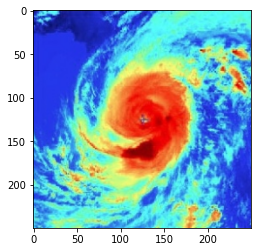

In [ ]:
#print a random image from the dataset
import random
i = random.randint(0, 132)
img, label = dataset[i]
size = img.shape
print(f"INTENSITY: {label} KNOTS")
print(f"SIZE: {size}\n")
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
for i in range(132):
  x, y = dataset[i]
  # x = dataset[i]["image"]
  print(x.shape)

torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([3, 250, 250])
torch.Size([

In [ ]:
# RESIZE TO SAME
# DONE :D

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(                                                         #conv2d,batchnorm,relu,maxpool will execute in sequential manner by ussing nn.sequential
        nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1),                          #Applies a 2D convolution by multiply and add two matrices
        nn.BatchNorm2d(256),                                                            #To make training efficient dataset is scaled to 0 mean and 1 variance
        nn.ReLU(),                                                                      #To break down the linearity relu activation function is used
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2),                                                                #pool of square window of size=3(reduces feature size by taking only max,hence img size is reduced from 256-128-64-32-16)

        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Flatten(),                                                                       # used to convert multi-dimensional arrays into a 1-D array
        nn.Linear(784, 1),                                                                  # Out of 784 pixels need only one pixel hence used linear transformation
        )
  def forward(self, x):
    return self.model(x)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")                     # CUDA cores are 1000 times faster than cpu, used to increase the speed of execution
device

device(type='cuda', index=0)

In [ ]:
model = Model().to(device)                                                                   # to tell python to connect the cuda device
summary(model, (3, 250, 250))                                                                # Model summary is displayed

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 250, 250]           7,168
       BatchNorm2d-2        [-1, 256, 250, 250]             512
              ReLU-3        [-1, 256, 250, 250]               0
            Conv2d-4        [-1, 256, 250, 250]         590,080
       BatchNorm2d-5        [-1, 256, 250, 250]             512
              ReLU-6        [-1, 256, 250, 250]               0
         MaxPool2d-7        [-1, 256, 125, 125]               0
            Conv2d-8        [-1, 128, 125, 125]         295,040
       BatchNorm2d-9        [-1, 128, 125, 125]             256
             ReLU-10        [-1, 128, 125, 125]               0
           Conv2d-11        [-1, 128, 125, 125]         147,584
      BatchNorm2d-12        [-1, 128, 125, 125]             256
             ReLU-13        [-1, 128, 125, 125]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
loss_per_iteration = []

def train_batch(epochs, model, criterion, optimizer, train_loader):
  total = 0
  correct = 0
  for i in range(epochs):
    train_loss = 0.0
    for inputs, labels in train_loader:                                                  # Train_loader continously provide images
      inputs, labels = inputs.to(device), labels.to(device)                              # get the inputs, labels
      outputs = model(inputs)
      labels = torch.unsqueeze(labels, 1)                                                # unsqueeze is a method to change the tensor dimensions
      loss = criterion(outputs, labels)
      optimizer.zero_grad()                                                              # zero the parameter gradients
      loss.backward()                                                                    # Takes loss and track backward to update the weights
      optimizer.step()                                                                   # Perform single optimization step
      train_loss = train_loss + loss.item()


    print(f"Epoch: {i}/{epochs} Loss: {train_loss/len(train_loader):.5f} ")
    loss_per_iteration.append(train_loss/len(train_loader))

    return loss_per_iteration

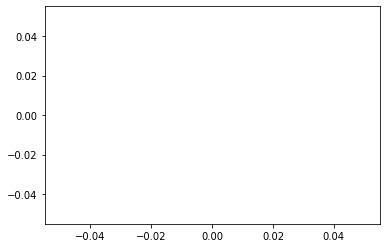

In [ ]:
plt.plot(loss_per_iteration)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb 25 12:05:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |   4461MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = Model().to(device)                                                                # model is originally stored on CPU, and then I want to move it to GPU0
criterion = nn.MSELoss()                                                                  # Creates a criterion that measures the mean squared error
optimizer = torch.optim.Adam(model.parameters(), lr =0.001)                               # Adam is one of the standard optimizer, require fewer parameters for tuning

history = train_batch(epochs=35,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            train_loader = data_loader)

Epoch: 0/35 Loss: 2561.96440 


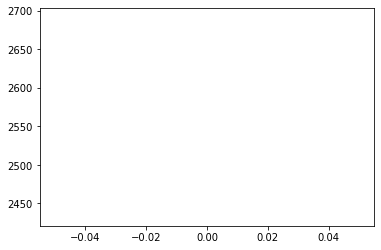

In [ ]:
plt.plot(history)

In [ ]:
model.eval()

Model(
  (model): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [ ]:
img = cv2.imread('/content/drive/MyDrive/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL/101.jpg')
img = np.array(img)                                                                   # Convert image into array
totensor = transforms.ToTensor()
img = totensor(img)                                                                   # Convert numpy.ndarray to tensor
resize = transforms.Resize(size=(248, 248))                                           # Resie the image
img = resize(img)
img = torch.unsqueeze(img, 0)                                                         # change dimensions of image
img = img.to(device)
model(img)

tensor([[11.1255]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
img = cv2.imread('/content/drive/MyDrive/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL/102.jpg')
img = np.array(img)
totensor = transforms.ToTensor()
img = totensor(img)
resize = transforms.Resize(size=(248, 248))
img = resize(img)
img = torch.unsqueeze(img, 0)
img = img.to(device)
model(img)

tensor([[10.4201]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
saved_path = './saved_modelcyclonr'
torch.save(model.state_dict(), saved_path)

In [ ]:
torch.save(model.state_dict,'cyclonemodel2.h5')

In [ ]:
torch.save(model.state_dict,'cyclonemodel2.pth')

In [ ]:
model= Model()
model.load_state_dict(torch.load('/content/saved_modelcyclonr', map_location=torch.device('cpu')))
model.eval()

Model(
  (model): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [ ]:
path = '/content/drive/MyDrive/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL/111.jpg'
img = cv2.imread(path)
img = np.array(img)
totensor = transforms.ToTensor()
img = totensor(img)
resize = transforms.Resize(size=(250, 250))
img = resize(img)
img = torch.unsqueeze(img, 0)
# img = img.to(device)
model(img)

tensor([[10.7464]], grad_fn=<AddmmBackward0>)

In [ ]:
path = '/content/drive/MyDrive/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL/118.jpg'
img = cv2.imread(path)
img = np.array(img)
totensor = transforms.ToTensor()
img = totensor(img)
resize = transforms.Resize(size=(250, 250))
img = resize(img)
img = torch.unsqueeze(img, 0)
# img = img.to(device)
model(img)

tensor([[12.3261]], grad_fn=<AddmmBackward0>)

In [ ]:
from google.colab import files
files.download('/content/saved_modelcyclonr')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---



In [ ]:
path = '/content/drive/MyDrive/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED/119.jpg'
img = cv2.imread(path)
img = np.array(img)
totensor = transforms.ToTensor()
img = totensor(img)
resize = transforms.Resize(size=(250, 250))
img = resize(img)
img = torch.unsqueeze(img, 0)
model(img).item()

25.25889015197754